# DATABASE

## Fuente de la base datos
La base de datos empleada corresponde al proyecto BIG-P3 BCI Dataset, disponible en la plataforma PhysioNet. Puede accederse directamente a través del siguiente enlace:

https://physionet.org/content/bigp3bci/1.0.0/#files-panel

### 1. Preparación e Instalación de Librerías
Instala MNE-Python (para análisis de EEG) y pyedflib (para leer archivos .edf). El EDF (European Data Format) es un formato estándar para el almacenamiento de datos de EEG.

In [12]:
pip install mne pyedflib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Carga y Visualización de Datos Crudos (Raw Data) y de Canales EEG
Se carga el archivo EDF y se inspecciona la estructura inicial de los datos y se aísla la señal cerebral de los canales de control..

Extracting EDF parameters from C:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Proyecto\Base de datos\J_01_SE001_RC_Test02.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11135  =      0.000 ...    43.496 secs...


C:\Users\franc\AppData\Local\Temp\ipykernel_25060\3036513149.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria
C:\Users\franc\AppData\Local\Temp\ipykernel_25060\3036513149.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria


<RawEDF | J_01_SE001_RC_Test02.edf, 62 x 11136 (43.5 s), ~5.3 MiB, data loaded>
['EEG_F3', 'EEG_Fz', 'EEG_F4', 'EEG_T7', 'EEG_C3', 'EEG_Cz', 'EEG_C4', 'EEG_T8', 'EEG_CP3', 'EEG_CP4', 'EEG_P3', 'EEG_Pz', 'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz', 'A_1_1', 'B_1_2', 'C_1_3', 'D_1_4', 'E_1_5', 'F_1_6', 'G_2_1', 'H_2_2', 'I_2_3', 'J_2_4', 'K_2_5', 'L_2_6', 'M_3_1', 'N_3_2', 'O_3_3', 'P_3_4', 'Q_3_5', 'R_3_6', 'S_4_1', 'T_4_2', 'U_4_3', 'V_4_4', 'W_4_5', 'X_4_6', 'Y_5_1', 'Z_5_2', 'Sp_5_3', '1_5_4', '2_5_5', '3_5_6', '4_6_1', '5_6_2', '6_6_3', '7_6_4', '8_6_5', '9_6_6', 'StimulusType', 'SelectedTarget', 'SelectedRow', 'SelectedColumn', 'PhaseInSequence', 'StimulusBegin', 'StimulusCode', 'CurrentTarget', 'FakeFeedback', 'DisplayResults']


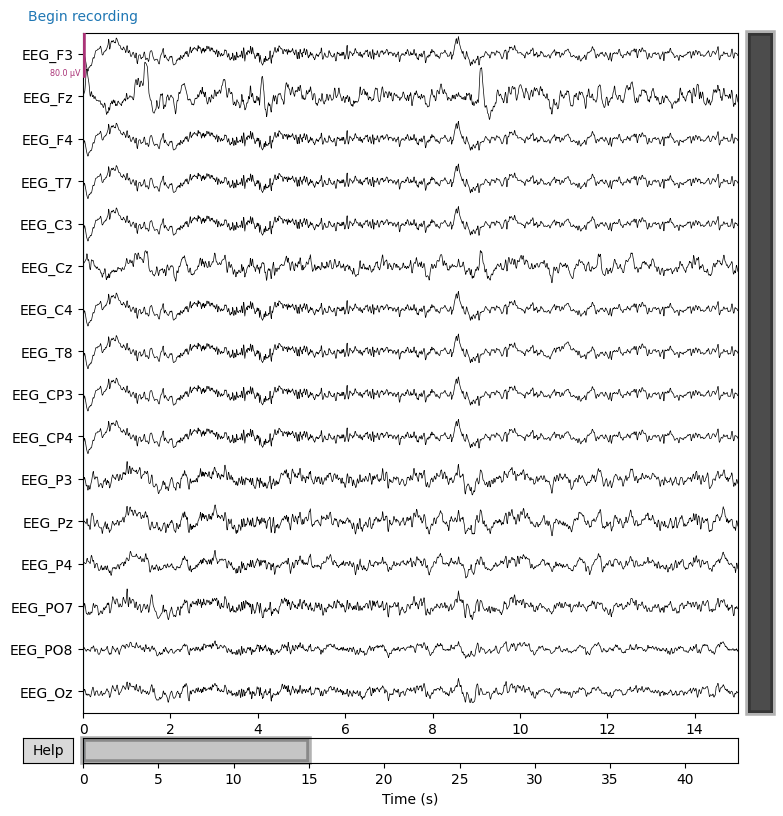

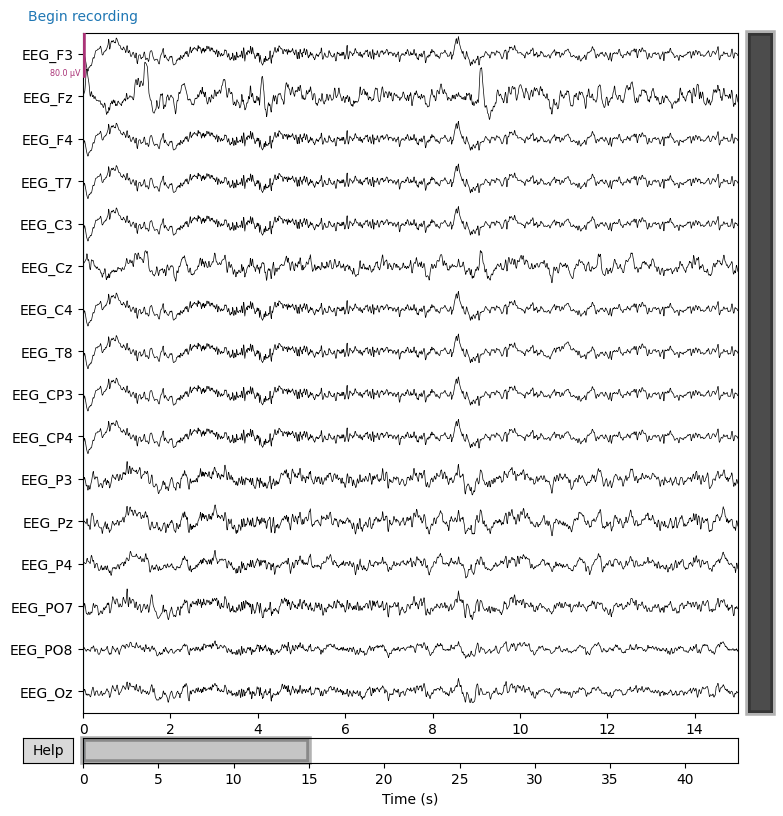

In [13]:
import mne
import os # Para obtener el archivo desde una ruta específica

# definir la ruta base y el nombre del archivo
base_path = r"C:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Proyecto\Base de datos"
file_name = "J_01_SE001_RC_Test02.edf"

# crear la ruta completa combinando base_path y file_name
file = os.path.join(base_path, file_name)

raw = mne.io.read_raw_edf(file, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria

print(raw) # Información general sobre los datos cargados
print(raw.info["ch_names"]) #Muesta la lista completa de nombres de canales

# Seleccionar solo canales que empiezan con "EEG_"
eeg_chs = [ch for ch in raw.ch_names if ch.startswith("EEG_")]

raw_eeg = raw.copy().pick(eeg_chs)

raw_eeg.plot(
    n_channels=len(raw_eeg.ch_names),
    duration=15,
    scalings=dict(eeg=40e-6) # Ajusta la escala de visualización - 40 µV por división
)

### 3. Detección y Creación de Eventos (Epoching)
Esta es la parte central para un BCI P300, donde se segmentan los datos alrededor de los estímulos.

In [14]:
import numpy as np
import mne

# --- 1. Extraer StimulusCode ---
# Extrae los datos del canal StimulusCode, que contiene
# el trigger digital que indica qué fila (1–6) o columna (7–12) acaba de parpadear.
stim = raw.copy().pick(["StimulusCode"])[0][0][0]

# --- 2. Detectar eventos REALMENTE ---
# Tomamos solo las transiciones donde StimulusCode pasa de 0 -> valor

# El bucle detecta el momento exacto (índice de muestra) en que el canal 
# StimulusCode pasa de 0 (no hay parpadeo) a un valor entre 1 y 12 (inicio de un parpadeo).
events = []
for i in range(1, len(stim)):
    if stim[i] != 0 and stim[i-1] == 0:
        events.append([i, 0, int(stim[i])])

events = np.array(events, dtype=int) # crea un array numpy de eventos

print("Eventos detectados:", events[:20])

# --- 3. Definir event_id ---
# Filas 1–6, Columnas 7–12, para asignar nombres a los códigos de evento
event_id = {
    "row_1": 1,
    "row_2": 2,
    "row_3": 3,
    "row_4": 4,
    "row_5": 5,
    "row_6": 6,
    "col_1": 7,
    "col_2": 8,
    "col_3": 9,
    "col_4": 10,
    "col_5": 11,
    "col_6": 12,
}

# --- 4. Crear epochs ---
# Extrae segmentos desde 100 ms antes del estímulo hasta 800 ms después.
tmin = -0.1
tmax = 0.8

epochs = mne.Epochs(
    raw_eeg,
    events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=(None, 0),
    preload=True
)

print(epochs)

# debería mostrar los epochs creados:
#MNE: [índice_muestra, 0 (siempre 0), código_evento (1-12)]


Eventos detectados: [[1152    0    3]
 [1184    0    5]
 [1216    0    6]
 [1248    0    7]
 [1280    0    4]
 [1312    0   11]
 [1344    0    1]
 [1376    0   12]
 [1408    0   10]
 [1440    0    2]
 [1472    0    8]
 [1504    0    9]
 [1536    0   11]
 [1568    0    3]
 [1600    0    1]
 [1632    0    4]
 [1664    0    7]
 [1696    0    8]
 [1728    0    2]
 [1760    0   10]]
Not setting metadata
116 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 116 events and 232 original time points ...
0 bad epochs dropped
<Epochs | 116 events (all good), -0.102 – 0.801 s (baseline -0.102 – 0 s), ~3.3 MiB, data loaded,
 'row_1': 9
 'row_2': 10
 'row_3': 9
 'row_4': 10
 'row_5': 10
 'row_6': 10
 'col_1': 9
 'col_2': 11
 'col_3': 10
 'col_4': 9
 and 2 more events ...>


### 4. Análisis de la Señal Promediada (Evoked Potentials)

C:\Users\franc\AppData\Local\Temp\ipykernel_25060\2180486912.py:21: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds, picks="EEG_Cz", colors=colors)


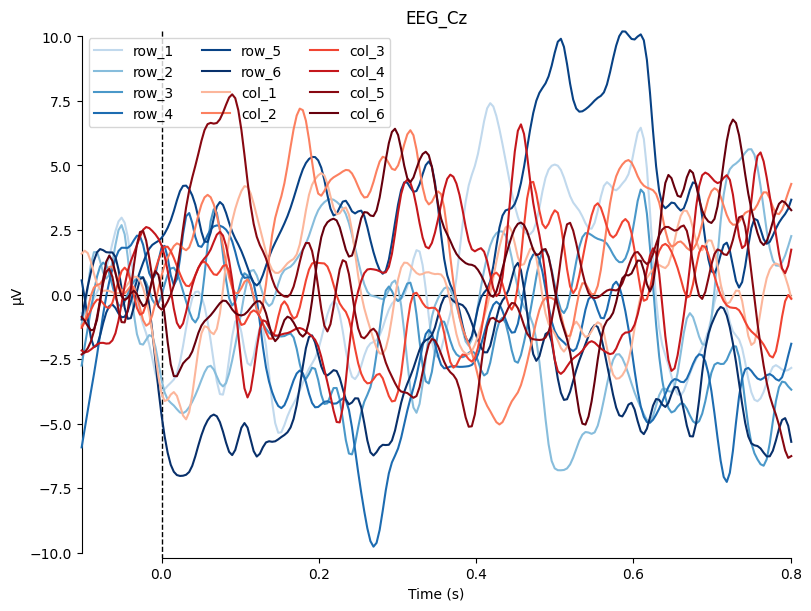

[<Figure size 800x600 with 1 Axes>]

In [15]:
### Version 1 de colores 
# Filas: tonos de azul 
# Columnas: tonos de rojo 

import matplotlib.pyplot as plt

evokeds = {cond: epochs[cond].average() for cond in epochs.event_id.keys()}
# Calcula las respuestas evocadas (promedio de EEG) para cada una de las 12 condiciones (6 filas, 6 columnas).

rows = [c for c in evokeds.keys() if "row" in c]
cols = [c for c in evokeds.keys() if "col" in c]

colors = {}

for i, r in enumerate(rows):
    colors[r] = plt.cm.Blues((i+1)/len(rows)+0.1)

for i, c in enumerate(cols):
    colors[c] = plt.cm.Reds((i+1)/len(cols)+0.1)

mne.viz.plot_compare_evokeds(evokeds, picks="EEG_Cz", colors=colors)
# Grafica todas las respuestas evocadas, comparándolas en el canal 
# EEG_Cz (un canal central que a menudo muestra la P300).


C:\Users\franc\AppData\Local\Temp\ipykernel_25060\1501464184.py:12: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds( evokeds, picks="EEG_Cz", colors=colors, legend='upper right' )


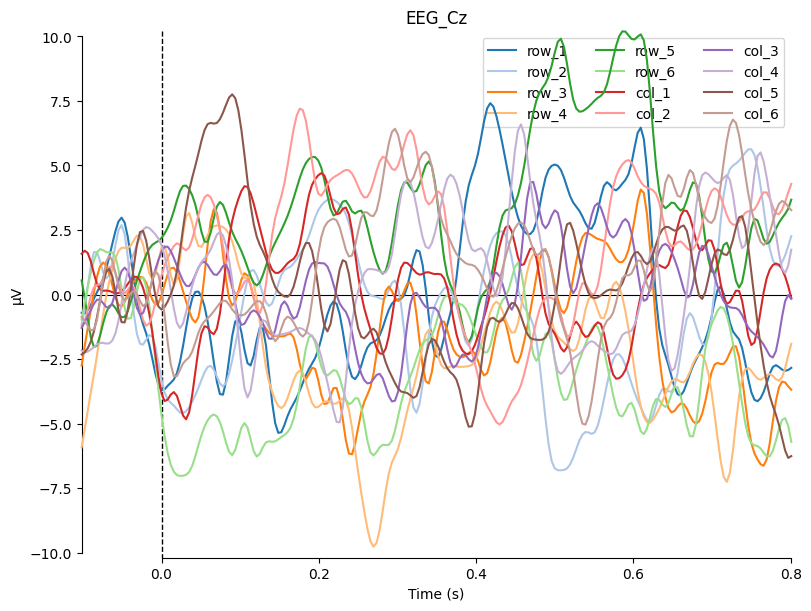

[<Figure size 800x600 with 1 Axes>]

In [16]:
### Version 2 de colores 

import matplotlib.pyplot as plt

# 20 colores disponibles, más que suficiente para 12 condiciones
base_colors = plt.cm.tab20.colors  

evokeds = {cond: epochs[cond].average() for cond in epochs.event_id.keys()}

colors = {cond: base_colors[i] for i, cond in enumerate(evokeds.keys())}

mne.viz.plot_compare_evokeds( evokeds, picks="EEG_Cz", colors=colors, legend='upper right' )

### 5. Cálculo de Amplitud del P300
El código busca cuantificar la P300, típicamente la característica más prominente en este experimento.

In [17]:
import numpy as np

p300_window = (0.3, 0.6) # de 300 ms a 600 ms

p300_amplitudes = {}
for cond, evk in evokeds.items():
    data = evk.copy().pick("EEG_Pz").data[0] # canal parietal, donde la P300 suele ser más fuerte
    times = evk.times
    idx = np.where((times >= p300_window[0]) & (times <= p300_window[1]))[0]
    p300_amplitudes[cond] = data[idx].mean()

p300_amplitudes #en Volts 


{'row_1': 1.1587301587301569e-07,
 'row_2': -1.5168311688311689e-06,
 'row_3': 3.4936411736411776e-07,
 'row_4': -3.732442712842712e-06,
 'row_5': 5.561897546897547e-06,
 'row_6': 1.2603489177489174e-06,
 'col_1': -3.747166907166907e-07,
 'col_2': -1.0785761511216055e-06,
 'col_3': 3.1818874458874467e-07,
 'col_4': 1.5516459836459835e-06,
 'col_5': 5.700571428571427e-07,
 'col_6': -7.035760782427452e-07}

### 6. Decodificación y Letra Seleccionada
Se aplica la lógica de un P300 Speller para determinar la letra.

In [18]:
rows = {k:v for k,v in p300_amplitudes.items() if "row" in k} # Filas
cols = {k:v for k,v in p300_amplitudes.items() if "col" in k} # Columnas

row_selected = max(rows, key=rows.get) # encuentra la fila con la máxima amplitud P300.
col_selected = max(cols, key=cols.get) # encuentra la columna con la máxima amplitud P300.

row_selected, col_selected

('row_5', 'col_4')

In [19]:
### BUSCANDO LETRA EN MATRIZ
matrix = [
    ["A","B","C","D","E","F"],
    ["G","H","I","J","K","L"],
    ["M","N","O","P","Q","R"],
    ["S","T","U","V","W","X"],
    ["Y","Z","1","2","3","4"],
    ["5","6","7","8","9","0"],
]
def letra(row_name, col_name):
    # Extraer el número de la fila (ej. 'row_4' -> 4)
    row_num = int(row_name.split('_')[1])
    # Extraer el número de la columna (ej. 'col_3' -> 3)
    col_num = int(col_name.split('_')[1])
    
    # Python usa índices basados en 0, por lo que restamos 1.
    row_index = row_num - 1
    col_index = col_num - 1
    
    # Devolver el elemento en la matriz
    return matrix[row_index][col_index]

print(letra(row_selected, col_selected))


2


### 7. Análisis del Canal de Estímulo

In [20]:
events = mne.find_events(raw, stim_channel="StimulusCode")
print(events[:20])

Finding events on: StimulusCode
116 events found on stim channel StimulusCode
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
[[1152    0    3]
 [1184    0    5]
 [1216    0    6]
 [1248    0    7]
 [1280    0    4]
 [1312    0   11]
 [1344    0    1]
 [1376    0   12]
 [1408    0   10]
 [1440    0    2]
 [1472    0    8]
 [1504    0    9]
 [1536    0   11]
 [1568    0    3]
 [1600    0    1]
 [1632    0    4]
 [1664    0    7]
 [1696    0    8]
 [1728    0    2]
 [1760    0   10]]


Esta gráfica muestra una señal de "escalones" (cuadrada). Cuando el canal está en 0, no hay parpadeo. Cuando sube a un valor (1 a 12), indica el inicio de un parpadeo de una fila o columna específica. Esto confirma el funcionamiento del trigger utilizado para el epoching.

Eje x: Samples

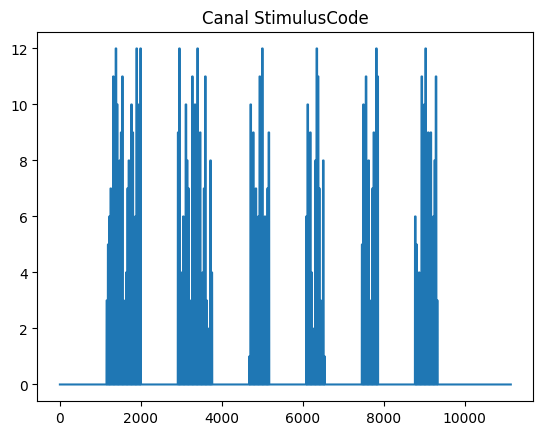

In [21]:
import matplotlib.pyplot as plt

stim = raw.get_data(picks="StimulusCode")[0]
plt.plot(stim)
plt.title("Canal StimulusCode")
plt.show()

## Viendo eventos [donde ocurrió el estímulo- canal (siempre 0 en MNE para eventos) - #row/colum]

In [22]:
events = mne.find_events(raw, stim_channel="StimulusCode", shortest_event=1)
print(events[:40])

Finding events on: StimulusCode
116 events found on stim channel StimulusCode
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
[[1152    0    3]
 [1184    0    5]
 [1216    0    6]
 [1248    0    7]
 [1280    0    4]
 [1312    0   11]
 [1344    0    1]
 [1376    0   12]
 [1408    0   10]
 [1440    0    2]
 [1472    0    8]
 [1504    0    9]
 [1536    0   11]
 [1568    0    3]
 [1600    0    1]
 [1632    0    4]
 [1664    0    7]
 [1696    0    8]
 [1728    0    2]
 [1760    0   10]
 [1792    0    9]
 [1824    0    5]
 [1856    0    6]
 [1888    0   12]
 [1920    0   10]
 [1952    0    4]
 [1984    0   12]
 [2912    0    9]
 [2944    0   12]
 [2976    0    2]
 [3008    0    4]
 [3040    0    6]
 [3072    0    5]
 [3104    0   10]
 [3136    0    8]
 [3168    0    7]
 [3200    0    3]
 [3232    0    1]
 [3264    0   11]
 [3296    0    8]]


### Otro ejemplo:

Extracting EDF parameters from C:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Proyecto\Base de datos\J_01_SE001_RC_Test01.edf...
Setting channel info structure...
Creating raw.info structure...


Reading 0 ... 10911  =      0.000 ...    42.621 secs...
<RawEDF | J_01_SE001_RC_Test01.edf, 62 x 10912 (42.6 s), ~5.2 MiB, data loaded>
['EEG_F3', 'EEG_Fz', 'EEG_F4', 'EEG_T7', 'EEG_C3', 'EEG_Cz', 'EEG_C4', 'EEG_T8', 'EEG_CP3', 'EEG_CP4', 'EEG_P3', 'EEG_Pz', 'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz', 'A_1_1', 'B_1_2', 'C_1_3', 'D_1_4', 'E_1_5', 'F_1_6', 'G_2_1', 'H_2_2', 'I_2_3', 'J_2_4', 'K_2_5', 'L_2_6', 'M_3_1', 'N_3_2', 'O_3_3', 'P_3_4', 'Q_3_5', 'R_3_6', 'S_4_1', 'T_4_2', 'U_4_3', 'V_4_4', 'W_4_5', 'X_4_6', 'Y_5_1', 'Z_5_2', 'Sp_5_3', '1_5_4', '2_5_5', '3_5_6', '4_6_1', '5_6_2', '6_6_3', '7_6_4', '8_6_5', '9_6_6', 'StimulusType', 'SelectedTarget', 'SelectedRow', 'SelectedColumn', 'PhaseInSequence', 'StimulusBegin', 'StimulusCode', 'CurrentTarget', 'FakeFeedback', 'DisplayResults']


C:\Users\franc\AppData\Local\Temp\ipykernel_25060\2406057021.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw2 = mne.io.read_raw_edf(file2, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria
C:\Users\franc\AppData\Local\Temp\ipykernel_25060\2406057021.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw2 = mne.io.read_raw_edf(file2, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria


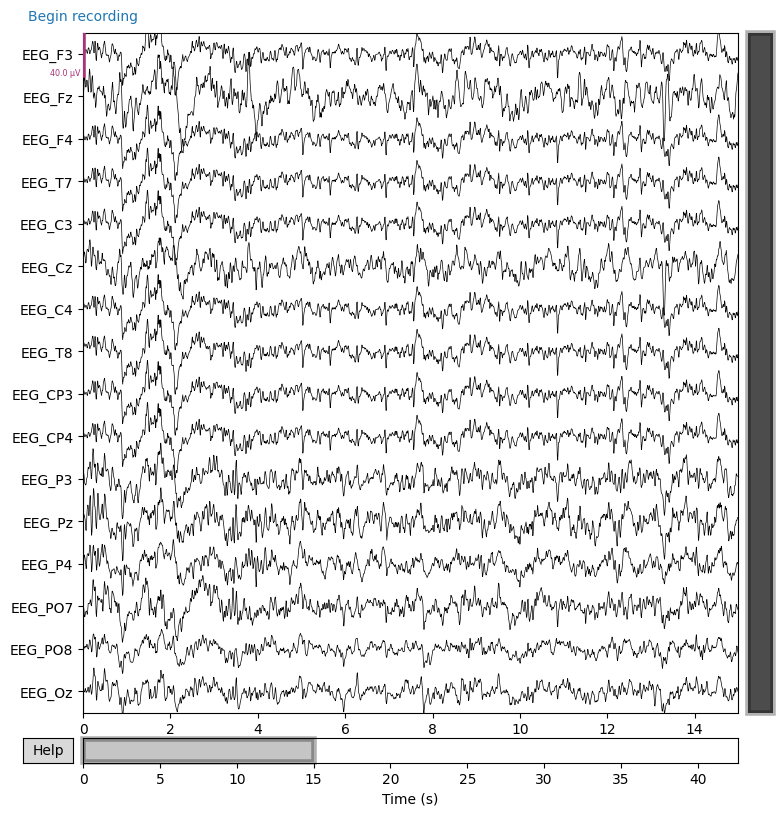

Eventos detectados: [[1152    0   11]
 [1184    0    4]
 [1216    0    6]
 [1248    0    3]
 [1280    0   12]
 [1312    0    2]
 [1344    0    9]
 [1376    0    1]
 [1408    0    7]
 [1440    0    8]
 [1472    0   10]
 [1504    0    5]
 [1536    0    2]
 [1568    0    8]
 [1600    0    9]
 [1632    0   12]
 [1664    0    4]
 [2592    0   10]
 [2624    0    1]
 [2656    0    3]]
Not setting metadata
109 matching events found
Setting baseline interval to [-0.1015625, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 109 events and 232 original time points ...
0 bad epochs dropped
<Epochs | 109 events (all good), -0.102 – 0.801 s (baseline -0.102 – 0 s), ~3.1 MiB, data loaded,
 'row_1': 9
 'row_2': 9
 'row_3': 8
 'row_4': 10
 'row_5': 9
 'row_6': 8
 'col_1': 9
 'col_2': 10
 'col_3': 9
 'col_4': 8
 and 2 more events ...>


C:\Users\franc\AppData\Local\Temp\ipykernel_25060\2406057021.py:100: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds2, picks="EEG_Cz", colors=colors2)


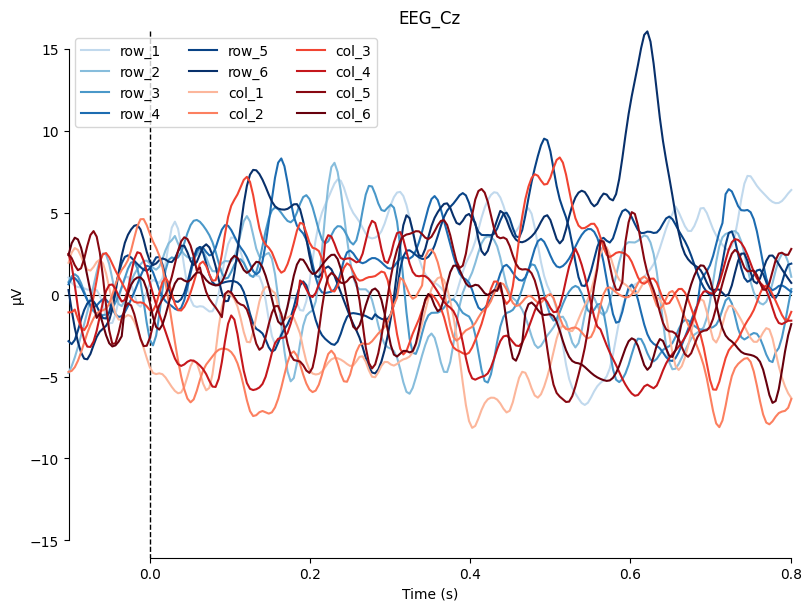

C:\Users\franc\AppData\Local\Temp\ipykernel_25060\2406057021.py:112: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds( evokeds2, picks="EEG_Cz", colors=colors2, legend='upper right' )


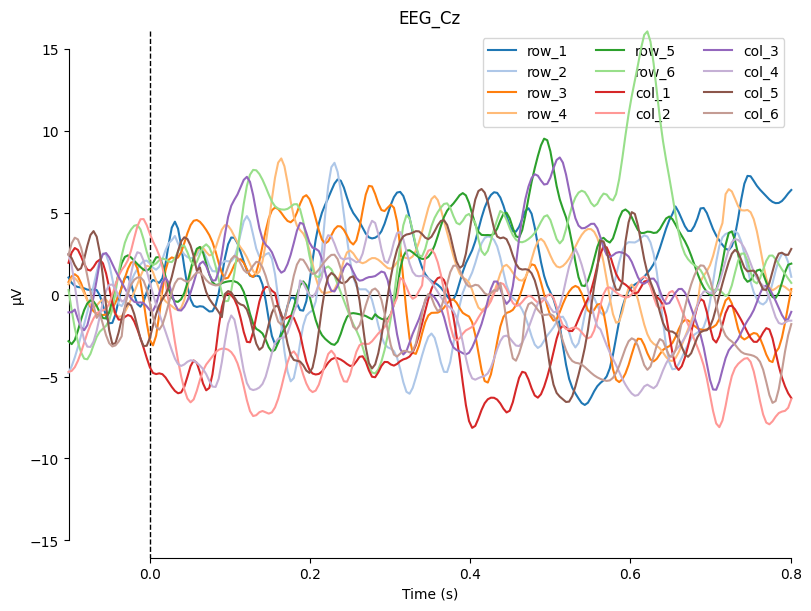

U


In [23]:
import mne
import os # Para obtener el archivo desde una ruta específica
import numpy as np

# definir la ruta base y el nombre del archivo
base_path = r"C:\Users\franc\Franco\2025-2\INTRO A SEÑALES BIOMEDICAS\PROYECTO\GRUPO-08-ISB-2025-II\Proyecto\Base de datos"
file_name2 = "J_01_SE001_RC_Test01.edf"

# crear la ruta completa combinando base_path y file_name
file2 = os.path.join(base_path, file_name2)

raw2 = mne.io.read_raw_edf(file2, preload=True) #Los datos del archivo EDF se cargan en un objeto Raw de MNE y en memoria

print(raw2) # Información general sobre los datos cargados
print(raw2.info["ch_names"]) #Muesta la lista completa de nombres de canales

# Seleccionar solo canales que empiezan con "EEG_"
eeg_chs2 = [ch for ch in raw2.ch_names if ch.startswith("EEG_")]

raw_eeg2 = raw2.copy().pick(eeg_chs2)

raw_eeg2.plot(
    n_channels=len(raw_eeg2.ch_names),
    duration=15,
    scalings=dict(eeg2=40e-6) # Ajusta la escala de visualización - 40 µV por división
)

# --- 1. Extraer StimulusCode ---
# Extrae los datos del canal StimulusCode, que contiene
# el trigger digital que indica qué fila (1–6) o columna (7–12) acaba de parpadear.
stim2 = raw2.copy().pick(["StimulusCode"])[0][0][0]

# --- 2. Detectar eventos REALMENTE ---
# Tomamos solo las transiciones donde StimulusCode pasa de 0 -> valor

# El bucle detecta el momento exacto (índice de muestra) en que el canal 
# StimulusCode pasa de 0 (no hay parpadeo) a un valor entre 1 y 12 (inicio de un parpadeo).
events2 = []
for i in range(1, len(stim2)):
    if stim2[i] != 0 and stim2[i-1] == 0:
        events2.append([i, 0, int(stim2[i])])

events2 = np.array(events2, dtype=int) # crea un array numpy de eventos

print("Eventos detectados:", events2[:20])

# --- 3. Definir event_id ---
# Filas 1–6, Columnas 7–12, para asignar nombres a los códigos de evento
event_id2 = {
    "row_1": 1,
    "row_2": 2,
    "row_3": 3,
    "row_4": 4,
    "row_5": 5,
    "row_6": 6,
    "col_1": 7,
    "col_2": 8,
    "col_3": 9,
    "col_4": 10,
    "col_5": 11,
    "col_6": 12,
}

# --- 4. Crear epochs ---
# Extrae segmentos desde 100 ms antes del estímulo hasta 800 ms después.
tmin = -0.1
tmax = 0.8

epochs2 = mne.Epochs(
    raw_eeg2,
    events2,
    event_id=event_id2,
    tmin=tmin,
    tmax=tmax,
    baseline=(None, 0),
    preload=True
)

print(epochs2)

# debería mostrar los epochs creados:
#MNE: [índice_muestra, 0 (siempre 0), código_evento (1-12)]

import matplotlib.pyplot as plt

evokeds2 = {cond: epochs2[cond].average() for cond in epochs2.event_id.keys()}
# Calcula las respuestas evocadas (promedio de EEG) para cada una de las 12 condiciones (6 filas, 6 columnas).

rows2 = [c for c in evokeds2.keys() if "row" in c]
cols2 = [c for c in evokeds2.keys() if "col" in c]

colors2 = {}

for i, r in enumerate(rows2):
    colors2[r] = plt.cm.Blues((i+1)/len(rows2)+0.1)

for i, c in enumerate(cols2):
    colors2[c] = plt.cm.Reds((i+1)/len(cols2)+0.1)

mne.viz.plot_compare_evokeds(evokeds2, picks="EEG_Cz", colors=colors2)
# Grafica todas las respuestas evocadas, comparándolas en el canal 
# EEG_Cz (un canal central que a menudo muestra la P300).

### Version 2 de colores 
# 20 colores disponibles, más que suficiente para 12 condiciones
base_colors = plt.cm.tab20.colors  

evokeds2 = {cond: epochs2[cond].average() for cond in epochs2.event_id.keys()}

colors2 = {cond: base_colors[i] for i, cond in enumerate(evokeds2.keys())}

mne.viz.plot_compare_evokeds( evokeds2, picks="EEG_Cz", colors=colors2, legend='upper right' )

import numpy as np

p300_window2 = (0.3, 0.6) # de 300 ms a 600 ms

p300_amplitudes2 = {}
for cond, evk in evokeds2.items():
    data = evk.copy().pick("EEG_Pz").data[0] # canal parietal, donde la P300 suele ser más fuerte
    times = evk.times
    idx = np.where((times >= p300_window2[0]) & (times <= p300_window2[1]))[0]
    p300_amplitudes2[cond] = data[idx].mean()

p300_amplitudes2 #en Volts 

rows = {k:v for k,v in p300_amplitudes2.items() if "row" in k} # Filas
cols = {k:v for k,v in p300_amplitudes2.items() if "col" in k} # Columnas

row_selected2 = max(rows, key=rows.get) # encuentra la fila con la máxima amplitud P300.
col_selected2 = max(cols, key=cols.get) # encuentra la columna con la máxima amplitud P300.

row_selected2, col_selected2


### BUSCANDO LETRA EN MATRIZ
matrix = [
    ["A","B","C","D","E","F"],
    ["G","H","I","J","K","L"],
    ["M","N","O","P","Q","R"],
    ["S","T","U","V","W","X"],
    ["Y","Z","1","2","3","4"],
    ["5","6","7","8","9","0"],
]
def letra(row_name, col_name):
    # Extraer el número de la fila (ej. 'row_4' -> 4)
    row_num = int(row_name.split('_')[1])
    # Extraer el número de la columna (ej. 'col_3' -> 3)
    col_num = int(col_name.split('_')[1])
    
    # Python usa índices basados en 0, por lo que restamos 1.
    row_index = row_num - 1
    col_index = col_num - 1
    
    # Devolver el elemento en la matriz
    return matrix[row_index][col_index]

print(letra(row_selected2, col_selected2))

